### Cargamos paquetes e instalamos las librerías a emplear

In [ ]:
!pip install holisticai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.8/288.8 kB 2.3 MB/s eta 0:00:00


In [ ]:
!pip install aif360

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 2.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot

from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import disparate_impact_ratio
from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.preprocessing import Reweighing

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


# Etapa de preprocesado y limpieza de los datos

In [ ]:
datos_victimas = pd.read_excel('/content/Cómo te afecta la discriminación la intolerancia y el odio.xlsx')
datos_victimas = datos_victimas.drop(datos_victimas.index[0])

In [ ]:
datos_victimas.shape

(238, 147)

In [ ]:
for element in datos_victimas.columns:
  print("Numero nulos columna {} ----> {}".format(element,datos_victimas[element].isnull().sum()))

Numero nulos columna respondent_id ----> 0
Numero nulos columna collector_id ----> 0
Numero nulos columna date_created ----> 0
Numero nulos columna date_modified ----> 0
Numero nulos columna ip_address ----> 0
Numero nulos columna email_address ----> 238
Numero nulos columna first_name ----> 238
Numero nulos columna last_name ----> 238
Numero nulos columna custom_1 ----> 238
Numero nulos columna Soy... ----> 0
Numero nulos columna Vivo en... ----> 0
Numero nulos columna He nacido en... ----> 0
Numero nulos columna Rango de Edad ----> 0
Numero nulos columna ¿Te identificas con alguno de estos colectivos? (Marca todas las opciones que sean pertinentes). ----> 90
Numero nulos columna Unnamed: 14 ----> 216
Numero nulos columna Unnamed: 15 ----> 233
Numero nulos columna Unnamed: 16 ----> 225
Numero nulos columna Unnamed: 17 ----> 226
Numero nulos columna Unnamed: 18 ----> 227
Numero nulos columna Unnamed: 19 ----> 189
Numero nulos columna Unnamed: 20 ----> 233
Numero nulos columna Unnamed: 

In [ ]:
for columnas in datos_victimas.columns:
  print(columnas)

respondent_id
collector_id
date_created
date_modified
ip_address
email_address
first_name
last_name
custom_1
Soy...
Vivo en...
He nacido en...
Rango de Edad
¿Te identificas con alguno de estos colectivos? (Marca todas las opciones que sean pertinentes).
Unnamed: 14
Unnamed: 15
Unnamed: 16
Unnamed: 17
Unnamed: 18
Unnamed: 19
Unnamed: 20
Unnamed: 21
Unnamed: 22
Unnamed: 23
¿Has asistido a alguna formación sobre cómo actuar en casos de discriminación, intolerancia y odio? (marca todas las que sean pertinentes)
Unnamed: 25
Unnamed: 26
Unnamed: 27
Unnamed: 28
Unnamed: 29
Unnamed: 30
Unnamed: 31
Unnamed: 32
¿Consideras que el discurso de odio (y los prejuicios que conlleva) y/o la discriminación que hay en la sociedad te afectan de alguna manera?  (marca todas las que procedan)
Unnamed: 34
Unnamed: 35
Unnamed: 36
Unnamed: 37
Unnamed: 38
¿Te has sentido alguna vez víctima de discriminaciones, agresiones o discurso de odio por tus condiciones personales (ser persona migrante, racializada,  muj

In [ ]:
columnas11 = [
    'Indica en qué grado (del 1 al 5) estás de acuerdo con estas afirmaciones, siendo 1 nada de acuerdo y 5 totalmente:',
    'Unnamed: 107',
    'Unnamed: 108',
    'Unnamed: 109',
    'Unnamed: 110',
    'Unnamed: 111',
    'Unnamed: 112',
    'Unnamed: 113',
    'Unnamed: 114',
    'Unnamed: 115',
    'Unnamed: 116',
    'Unnamed: 117',
    'Unnamed: 118',
    'Unnamed: 119',
    'Unnamed: 120',
    'Unnamed: 121'
]

columnas12 = [
    '¿Crees que existen recursos específicos para ayudarte a defenderte en casos de discurso y delito de odio y discriminación?',
    'Unnamed: 123'
]

In [ ]:
df = datos_victimas[columnas11]

df.replace({'Totalmente de acuerdo': 5, 'Nada de acuerdo': 1}, inplace=True)

df = df.apply(pd.to_numeric, errors='coerce')

for column in df.columns:
    mode = df[column].mode()[0]
    df[column].fillna(mode, inplace=True)

datos_victimas[columnas11] = df

datos_victimas['recursos_combinados'] = datos_victimas[columnas12].apply(lambda x: x['Unnamed: 123'] if x['¿Crees que existen recursos específicos para ayudarte a defenderte en casos de discurso y delito de odio y discriminación?'] == 'Sí (cuéntanos cuáles conoces en comentarios)' else x['¿Crees que existen recursos específicos para ayudarte a defenderte en casos de discurso y delito de odio y discriminación?'], axis=1)
datos_victimas['recursos_combinados'].fillna(datos_victimas['recursos_combinados'].mode()[0], inplace=True)
datos_victimas.drop(columns=columnas12, inplace=True)

datos_victimas.rename(columns={
    'Indica en qué grado (del 1 al 5) estás de acuerdo con estas afirmaciones, siendo 1 nada de acuerdo y 5 totalmente:':'Sé defenderme frente al discurso de odio',
    'Unnamed: 107':'Creo que, en general, las personas saben cómo actuar si detectan un discurso de odio',
    'Unnamed: 108':'Sé qué tengo que hacer para denunciar un delito de odio.',
    'Unnamed: 109':'No existe la discriminación en España.',
    'Unnamed: 110':'Nunca he sufrido discriminación en España.',
    'Unnamed: 111':'Los delitos de odio son raros sucesos difíciles de demostrar',
    'Unnamed: 112':'La policía no presta ayuda frente a los delitos de odio.',
    'Unnamed: 113':'Muchas veces son las propias instituciones las que discriminan a las personas a las que deben proteger',
    'Unnamed: 114':'Algunas personas no son conscientes de que expresan odio y prejuicios cuando hablan o publican algo en las redes',
    'Unnamed: 115':'Cuanto menos dinero tienes, más fácil es que te discriminen por tu origen, sexo, raza, religión, orientación sexual o diversidad funcional.',
    'Unnamed: 116':'La mayoría de las personas miran hacia otro lado cuando se produce un delito de odio o una discriminación',
    'Unnamed: 117':'Nunca denunciaría una discriminación o un delito de odio contra mi por miedo a las consecuencias',
    'Unnamed: 118':'Tengo miedo de denunciar si soy testigo de odio o discriminación por si hay represalias	Si veo una agresión por motivos de odio, defendería a la víctima sin dudarlo',
    'Unnamed: 119':'Si veo una agresion por motivos de odio, defendería a la víctima sin dudarlo',
    'Unnamed: 120':'Me gustaría formar parte de un grupo, asociación o colectivo que ayude a luchar contra el odio en todas sus formas (prejuicios, discurso, discriminación, delitos)',
    'Unnamed: 121':'Los chistes con prejuicios sobre colectivos vulnerables/minoritarios ayudan a que la gente sea permisiva con la discriminación'
}, inplace=True)

<ipython-input-9-9f0602b58128>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace({'Totalmente de acuerdo': 5, 'Nada de acuerdo': 1}, inplace=True)


In [ ]:
def codificacion_columnas(df, columnas_antiguas, columnas_nuevas):

    # Para asegurar que las columnas nuevas se ajusten a las antiguas
    if len(columnas_antiguas) != len(columnas_nuevas):
        raise ValueError("La cantidad de nombres de colectivos debe ser igual a la cantidad de columnas")

    # Inicializamos las nuevas columnas a 0
    for colectivo in columnas_nuevas:
        df[colectivo] = 0

    # Rellenamos las nuevas columnas con valores binarios según su pertenencia
    for index, row in df[columnas_antiguas].iterrows():
        for i, colectivo in enumerate(columnas_nuevas):
            if pd.notna(row[i]) and row[i] != 'nan':
                df.at[index, colectivo] = 1

    return df

In [ ]:
datos_victimas_nuevo = datos_victimas.copy()

columnas = [
    '¿Te identificas con alguno de estos colectivos? (Marca todas las opciones que sean pertinentes).',
    'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19',
    'Unnamed: 20', 'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23'
]

nombres_nuevos = [
    'Migrante', 'Homosexual/Bisexual', 'Transexual/Intersexual/No_Binario', 'Religion_minoritaria',
    'Diversidad_funcional', 'Persona_racializada', 'Persona_en_pobreza',
    'Persona_con_VIH', 'Mujer', 'Ninguno', 'otros'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas, nombres_nuevos)

##########################################
##########################################
##########################################

columnas2 = [
    '¿Has asistido a alguna formación sobre cómo actuar en casos de discriminación, intolerancia y odio? (marca todas las que sean pertinentes)',
    'Unnamed: 25', 'Unnamed: 26', 'Unnamed: 27', 'Unnamed: 28', 'Unnamed: 29', 'Unnamed: 30',
    'Unnamed: 31', 'Unnamed: 32']

nombres_nuevos2 = [
    'No_desinteresado', 'No, pero me interesaría asistir', 'No tengo formación, pero sí conocimientos prácticos', 'Tengo formación sobre qué es la discriminación y los delitos de odio',
    'Tengo formación sobre cómo actuar en casos de discriminación y delitos de odio', 'Tengo formación sobre qué es el discurso de odio', 'Tengo formación sobre cómo actuar en casos de discursos de odio',
    'Tengo formación sobre prejuicios y estereotipos', 'otro'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas2, nombres_nuevos2)

##########################################
##########################################
##########################################

columnas3 = [
    '¿Consideras que el discurso de odio (y los prejuicios que conlleva) y/o la discriminación que hay en la sociedad te afectan de alguna manera?  (marca todas las que procedan)',
    'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38']

nombres_nuevos3 = [
    'Afectan_personalmente', 'Afecta_a_terceros', 'Erosionan_instituciones', 'No',
    'No_sabe', 'otro'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas3, nombres_nuevos3)

##########################################
##########################################
##########################################

columnas4 = [
    '¿Te has sentido alguna vez víctima de discriminaciones, agresiones o discurso de odio por tus condiciones personales (ser persona migrante, racializada,  mujer, LGTBIQ+, estar en situación de probreza, etc...)? (Marca solamente aquellas que consideres haber sufrido)',
    'Unnamed: 40',
    'Unnamed: 41',
    'Unnamed: 42',
    'Unnamed: 43',
    'Unnamed: 44',
    'Unnamed: 45',
    'Unnamed: 46',
    'Unnamed: 47',
    'Unnamed: 48',
    'Unnamed: 49',
    'Unnamed: 50'
]

nombres_nuevos4 = [
    'Si_personalmente', 'Si_personalmente_redes_sociales', 'Si_agresion_fisica', 'Si_marginado_publico',
    'Si_marginado_social', 'Si_marginado_laboral', 'Si_alquiler_vivienda',
    'Si_bullying', 'Si_ciberbullying', 'Si_calle', 'No', 'otros'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas4, nombres_nuevos4)

##########################################
##########################################
##########################################

columnas5 = [
    'Si contestaste que sí a la pregunta anterior, ¿cómo ha afectado personalmente? (marca todas las que procedan)',
    'Unnamed: 52',
    'Unnamed: 53',
    'Unnamed: 54',
    'Unnamed: 55',
    'Unnamed: 56',
    'Unnamed: 57',
    'Unnamed: 58',
    'Unnamed: 59'
]

nombres_nuevos5 = [
    'Censura', 'Emocionalmente', 'Autoestima_afectada', 'Ausencia_rrss',
    'afecta_terceros', 'ocular_personalmente', 'limitar_presencia_fisica',
    'Desarrollo_vida_afectado', 'otros'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas5, nombres_nuevos5)

##########################################
##########################################
##########################################

columnas6 = [
    '¿Te has encontrado con discurso de odio (prejuicios, insultos, rechazo, bulos...) en las redes sociales?',
    'Unnamed: 61',
    'Unnamed: 62',
    'Unnamed: 63'
]

nombres_nuevos6 = [
    'Contra_mi', 'Contra_colectivo', 'Contra_otros_colectivos', 'otros'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas6, nombres_nuevos6)

##########################################
##########################################
##########################################

columnas7 = [
    'Si te encuentras ante un caso de discurso de odio en Internet, ¿cómo reaccionas?',
    'Unnamed: 65',
    'Unnamed: 66',
    'Unnamed: 67',
    'Unnamed: 68',
    'Unnamed: 69',
    'Unnamed: 70'
]

nombres_nuevos7 = [
    'Responder/Intervenir', 'Denuncio', 'Bloquear_persona', 'Denunciar_via_judicial',
    'No_hacer_caso', 'No_se_actuar', 'otros'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas7, nombres_nuevos7)

datos_victimas_nuevo['reaccion_internet_anterior'] = datos_victimas_nuevo['Si en la anterior pregunta has marcado "respondo/intervengo", ¿puedes contarnos algo sobre cómo lo haces?']

##########################################
##########################################
##########################################

columnas8 = [
    'Si alguna vez has sido víctima o testigo de discriminación o agresión física motivada por el odio (xenofobia, transfobia, racismo, machismo, y otras) ¿cómo has reaccionado? (puedes marcar varias opciones)',
    'Unnamed: 73',
    'Unnamed: 74',
    'Unnamed: 75',
    'Unnamed: 76',
    'Unnamed: 77',
    'Unnamed: 78',
    'Unnamed: 79',
    'Unnamed: 80',
    'Unnamed: 81'
]

nombres_nuevos8 = [
    'Cuento_lo_que_sucedio', 'Reclamo', 'Denuncia', 'Ignorar',
    'Grabar', 'Defender_victima', 'Apoyar_moralmente',
    'No_actuo', 'Voluntad_de_actuar', 'otros'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas8, nombres_nuevos8)

##########################################
##########################################
##########################################

columnas9 = [
    '¿Puedes especificar los colectivos y/o características personales contra los que ves más discurso de odio y discriminación? (puedes marcar varias opciones)',
    'Unnamed: 83',
    'Unnamed: 84',
    'Unnamed: 85',
    'Unnamed: 86',
    'Unnamed: 87',
    'Unnamed: 88',
    'Unnamed: 89',
    'Unnamed: 90',
    'Unnamed: 91',
    'Unnamed: 92',
    'Unnamed: 93',
    'Unnamed: 94',
    'Unnamed: 95',
    'Unnamed: 96'
]


nombres_nuevos9 = [
    'contra_migrantes', 'contra_menas', 'contra_otras_razas', 'contra_homosexuales_bisexuales',
    'contra_trans_inter', 'contra_musulmanes', 'contra_diversidad',
    'contra_persona_con_VIH', 'contra_pobres', 'contra_mujeres', 'contra_personas_misma_edad',
    'contra_personas_fisicamente', 'contra_judios', 'contra_gitanos', 'otros'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas9, nombres_nuevos9)

##########################################
##########################################
##########################################

columnas10 = ['¿Con qué frecuencia encuentras discriminación y odio contra los colectivos que marcaste en la pregunta anterior? ',
    'Unnamed: 98',
    'Unnamed: 99',
    'Unnamed: 100',
    'Unnamed: 101',
    'Unnamed: 102',
    'Unnamed: 103',
    'Unnamed: 104',
    'Unnamed: 105'
]


nombres_nuevos10 = [
    'redes_sociales', 'calle', 'trabajo', 'escuela',
    'servicios_publicos', 'medios_audiovisuales', 'discurso_politico',
    'espacios_privados_uso_publico', 'trato_personal'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas10, nombres_nuevos10)

##########################################
##########################################
##########################################

columnas13 = [
    '¿Qué cosas crees que te ayudarían a actuar en casos de discurso de odio, discriminación y delitos de odio? (marca todas las que quieras)',
    'Unnamed: 125',
    'Unnamed: 126',
    'Unnamed: 127',
    'Unnamed: 128',
    'Unnamed: 129',
    'Unnamed: 130'
]

nombres_nuevos13 = [
    'Formacion', 'Apps_moviles', 'Apoyo_profesional', 'Trabajo_en_red',
    'Tener_mas_tiempo', 'Ninguno', 'otros'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas13, nombres_nuevos13)

##########################################
##########################################
##########################################

columnas14 = [
    '¿Sobre qué temas te gustaría formarte para aprender a abordar casos de discursos de odio, discriminación y delitos de odio? (marca todas las pertinentes)',
    'Unnamed: 132',
    'Unnamed: 133',
    'Unnamed: 134',
    'Unnamed: 135',
    'Unnamed: 136',
    'Unnamed: 137',
    'Unnamed: 138',
    'Unnamed: 139',
    'Unnamed: 140',
    'Unnamed: 141',
    'Unnamed: 142',
    'Unnamed: 143',
    'Unnamed: 144',
    'Unnamed: 145'
]

nombres_nuevos14 = [
    'Identificar_discur_odio', 'Identificar_delitos_odio', 'Identificar_discriminacion', 'Identificar_bulos',
    'Como_actuar_frente_disc_odio', 'Como_actuar_frente_discriminacion', 'Como_actuar_frente_delitos_odio',
    'Conocer_mis_derechos', 'Activismo-ciberactivismo_contra_desinformacion', 'Dar_narrativa_contra_odio', 'Campaña_contra_odio',
    'Recursos_a_mi_disposicion', 'Volver_a_tener_autoestima', 'Ayudar_a_otros', 'otro'
]

datos_victimas_nuevo = codificacion_columnas(datos_victimas_nuevo, columnas14, nombres_nuevos14)

<ipython-input-10-28d59b053775>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[colectivo] = 0
<ipython-input-10-28d59b053775>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[colectivo] = 0
<ipython-input-10-28d59b053775>:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[colectivo] = 0
<ipy

In [ ]:
datos_victimas_new_nuevo = datos_victimas_nuevo.drop(columns = datos_victimas_nuevo.filter(regex="^Unnamed:").columns)

datos_victimas_new_nuevo1 = datos_victimas_new_nuevo.drop(columns = ['custom_1', 'collector_id', 'date_modified', 'date_created',
                                                                     'ip_address', 'email_address', 'first_name', 'last_name',
                                                                     'Si en la anterior pregunta has marcado "respondo/intervengo", ¿puedes contarnos algo sobre cómo lo haces?',
                                                                     'Si contestaste que sí a la pregunta anterior, ¿cómo ha afectado personalmente? (marca todas las que procedan)',
                                                                     'Si te encuentras ante un caso de discurso de odio en Internet, ¿cómo reaccionas?',
                                                                     'Si alguna vez has sido víctima o testigo de discriminación o agresión física motivada por el odio (xenofobia, transfobia, racismo, machismo, y otras) ¿cómo has reaccionado? (puedes marcar varias opciones)',
                                                                     '¡Ya hemos terminado! Si quieres que te informemos sobre cursos para actuar frente al odio y la discriminación, puedes dejarnos aquí tu correo electrónico. También puedes comentarnos lo que quieras. ¡Gracias!'])

datos_victimas_new_nuevo2 = datos_victimas_new_nuevo1.drop(columns = datos_victimas_new_nuevo1.columns[-1])

datos_victimas_new_nuevo3 = datos_victimas_new_nuevo2.drop(columns = datos_victimas_new_nuevo2.filter(regex="^¿").columns)

In [ ]:
for columnas in datos_victimas_new_nuevo3.columns:
  print('Columna {} -----> Nulos: {}'.format(columnas, datos_victimas_new_nuevo3[columnas].isnull().sum()))

Columna respondent_id -----> Nulos: 0
Columna Soy... -----> Nulos: 0
Columna Vivo en... -----> Nulos: 0
Columna He nacido en... -----> Nulos: 0
Columna Rango de Edad -----> Nulos: 0
Columna Sé defenderme frente al discurso de odio -----> Nulos: 0
Columna Creo que, en general, las personas saben cómo actuar si detectan un discurso de odio -----> Nulos: 0
Columna Sé qué tengo que hacer para denunciar un delito de odio. -----> Nulos: 0
Columna No existe la discriminación en España. -----> Nulos: 0
Columna Nunca he sufrido discriminación en España. -----> Nulos: 0
Columna Los delitos de odio son raros sucesos difíciles de demostrar -----> Nulos: 0
Columna La policía no presta ayuda frente a los delitos de odio. -----> Nulos: 0
Columna Muchas veces son las propias instituciones las que discriminan a las personas a las que deben proteger -----> Nulos: 0
Columna Algunas personas no son conscientes de que expresan odio y prejuicios cuando hablan o publican algo en las redes -----> Nulos: 0
Col

In [ ]:
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

datos_imputado = imputer.fit_transform(datos_victimas_new_nuevo3)
dataframe_pulido = pd.DataFrame(datos_imputado, columns=datos_victimas_new_nuevo3.columns)

In [ ]:
for columnas in dataframe_pulido.columns:
  print('Columna {} -----> Nulos: {}'.format(columnas, dataframe_pulido[columnas].isnull().sum()))

Columna respondent_id -----> Nulos: 0
Columna Soy... -----> Nulos: 0
Columna Vivo en... -----> Nulos: 0
Columna He nacido en... -----> Nulos: 0
Columna Rango de Edad -----> Nulos: 0
Columna Sé defenderme frente al discurso de odio -----> Nulos: 0
Columna Creo que, en general, las personas saben cómo actuar si detectan un discurso de odio -----> Nulos: 0
Columna Sé qué tengo que hacer para denunciar un delito de odio. -----> Nulos: 0
Columna No existe la discriminación en España. -----> Nulos: 0
Columna Nunca he sufrido discriminación en España. -----> Nulos: 0
Columna Los delitos de odio son raros sucesos difíciles de demostrar -----> Nulos: 0
Columna La policía no presta ayuda frente a los delitos de odio. -----> Nulos: 0
Columna Muchas veces son las propias instituciones las que discriminan a las personas a las que deben proteger -----> Nulos: 0
Columna Algunas personas no son conscientes de que expresan odio y prejuicios cuando hablan o publican algo en las redes -----> Nulos: 0
Col

In [ ]:
dataframe_final = pd.DataFrame()

dataframe_final['id'] = dataframe_pulido['respondent_id']
dataframe_final['genero'] = dataframe_pulido['Soy...']
dataframe_final['vivienda'] = dataframe_pulido['Vivo en...']
dataframe_final['birthplace'] = dataframe_pulido['He nacido en...']
dataframe_final['rango_edad'] = dataframe_pulido['Rango de Edad']

for columnas in dataframe_pulido.columns:
  if columnas != 'respondent_id' or columnas != 'Soy...' or columnas != 'Vivo en...' or columnas != 'He nacido en...' or columnas != 'Rango de Edad':
    dataframe_final[columnas] = dataframe_pulido[columnas]

dataframe_final.drop(columns = ['respondent_id', 'Soy...', 'Vivo en...', 'He nacido en...', 'Rango de Edad'], inplace=True)

<ipython-input-16-f29ccbfbeb35>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_final[columnas] = dataframe_pulido[columnas]
<ipython-input-16-f29ccbfbeb35>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataframe_final[columnas] = dataframe_pulido[columnas]
<ipython-input-16-f29ccbfbeb35>:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get 

In [ ]:
df_encoded = dataframe_final.copy()
le = LabelEncoder()
for column in dataframe_final.iloc[:, :6].columns:
    if column != "id":
        df_encoded[column] = le.fit_transform(df_encoded[column])

df_encoded['reaccion_internet_anterior'] = le.fit_transform(df_encoded['reaccion_internet_anterior'])
df_encoded['recursos_combinados'] = le.fit_transform(df_encoded['recursos_combinados'])
df_encoded

,id,genero,vivienda,birthplace,rango_edad,Sé defenderme frente al discurso de odio,"Creo que, en general, las personas saben cómo actuar si detectan un discurso de odio",Sé qué tengo que hacer para denunciar un delito de odio.,No existe la discriminación en España.,Nunca he sufrido discriminación en España.,...,Identificar_bulos,Como_actuar_frente_disc_odio,Como_actuar_frente_discriminacion,Como_actuar_frente_delitos_odio,Conocer_mis_derechos,Activismo-ciberactivismo_contra_desinformacion,Dar_narrativa_contra_odio,Campaña_contra_odio,Recursos_a_mi_disposicion,Volver_a_tener_autoestima
0,114174637251.0,0,7,3,3,3,2.0,4.0,1.0,4.0,...,0,0,0,0,0,1,1,0,0,0
1,114173740936.0,0,6,3,3,3,2.0,3.0,1.0,1.0,...,1,1,1,1,1,1,1,1,1,1
2,114173258674.0,0,6,3,2,3,2.0,3.0,1.0,1.0,...,0,0,1,0,1,1,1,1,1,1
3,114173178828.0,0,6,3,3,4,4.0,5.0,1.0,5.0,...,0,0,0,0,1,0,0,0,1,0
4,114173168151.0,0,6,3,2,2,3.0,3.0,3.0,2.0,...,0,1,1,1,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,114129178581.0,1,7,6,2,4,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
234,114129173887.0,1,6,1,1,3,4.0,2.0,3.0,2.0,...,1,1,1,1,1,1,0,1,0,0
235,114129164291.0,1,6,1,2,4,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
236,114129170730.0,1,6,0,0,4,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Empleo de Holistic AI (analítico) y la API de sklearn con AIF360 (corrección de sesgos)


<Axes: >

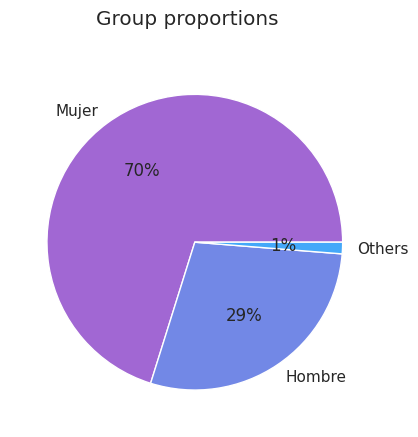

In [ ]:
group_pie_plot(dataframe_final['genero'])

<Axes: >

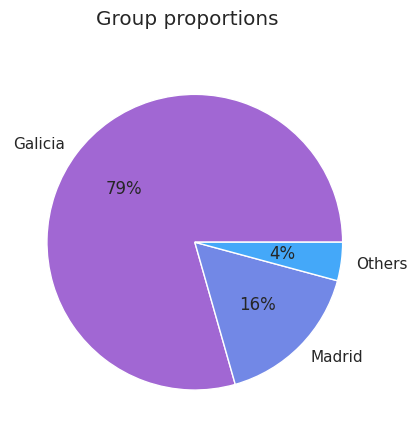

In [ ]:
group_pie_plot(dataframe_final['vivienda'])

<Axes: >

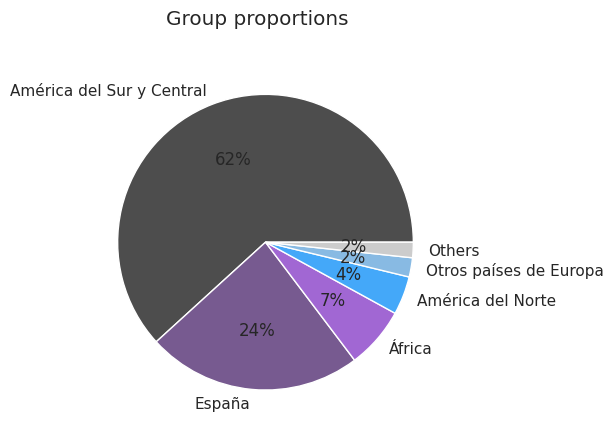

In [ ]:
group_pie_plot(dataframe_final['birthplace'])

<Axes: xlabel='Class', ylabel='Group'>

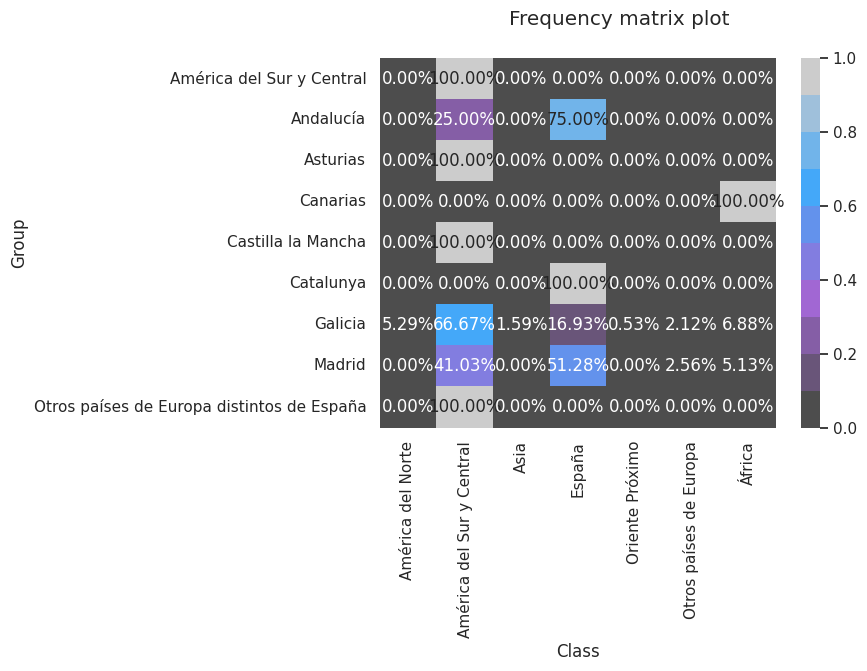

In [ ]:
frequency_matrix_plot(dataframe_final['vivienda'], dataframe_final['birthplace'], normalize='group')

<Axes: xlabel='Class', ylabel='Group'>

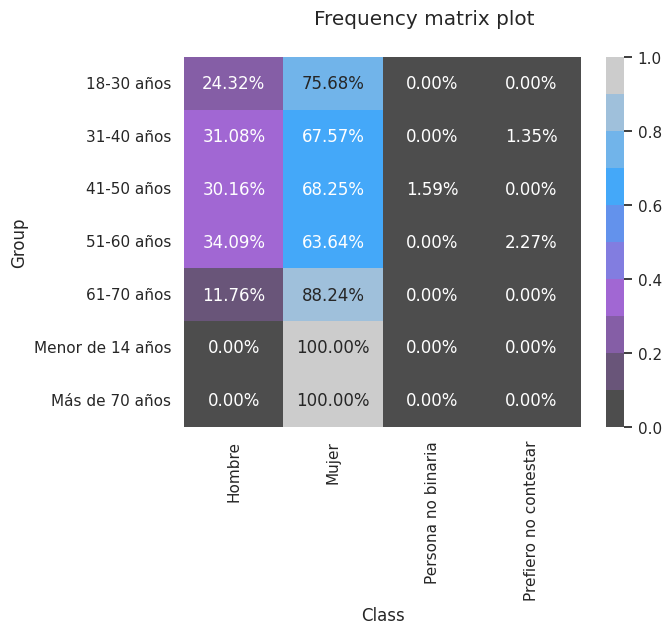

In [ ]:
frequency_matrix_plot(dataframe_final['rango_edad'], dataframe_final['genero'], normalize='group')

<Axes: xlabel='Class', ylabel='Group'>

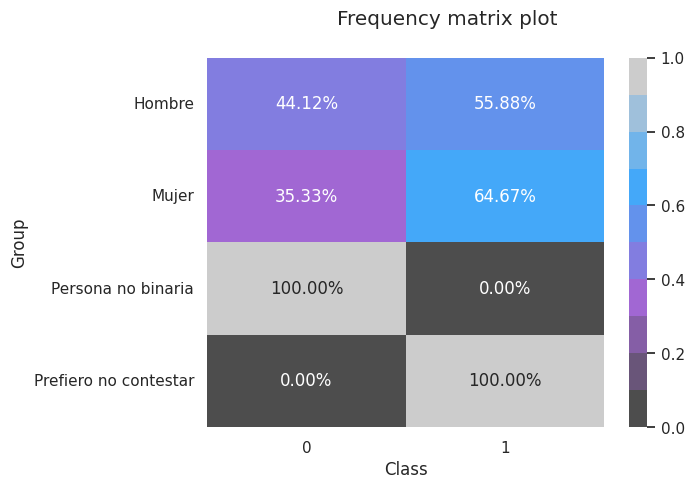

In [ ]:
frequency_matrix_plot(dataframe_final['genero'], dataframe_final['Migrante'], normalize='group')

<Axes: xlabel='rango_edad', ylabel='Probability'>

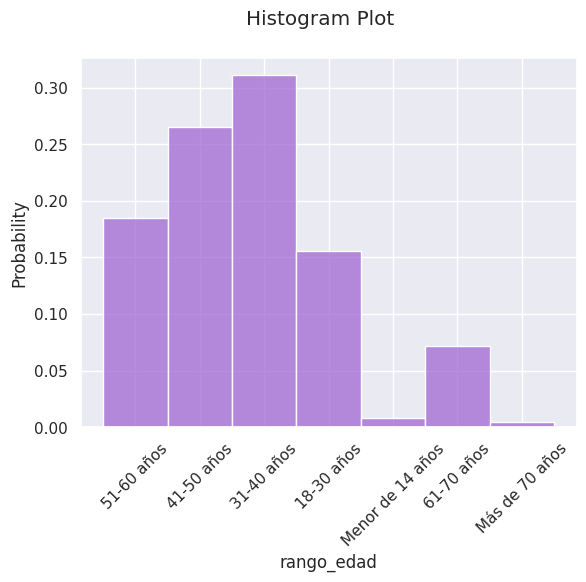

In [ ]:
histogram_plot(dataframe_final['rango_edad'])

<Axes: >

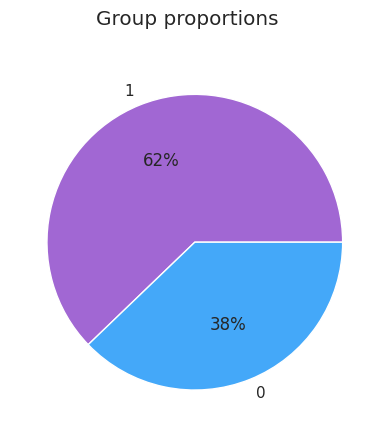

In [ ]:
group_pie_plot(dataframe_final['Migrante'])

In [ ]:
df_encoded.iloc[:, 1:].corr().style.background_gradient(cmap='coolwarm', axis=None)

# Corrección de sesgos

In [ ]:
df_encoded_analisis = df_encoded.copy()

df_encoded_analisis.drop('id', inplace=True, axis=1)#Eliminamos el id puesto que no nos interesa

#Establecemos como índices principales los atributos protegidos. Nos servirá para las métricas de fairness
df_encoded_analisis = df_encoded_analisis.set_index(['genero', 'Migrante'])

df_encoded_analisis

vivienda  birthplace  rango_edad  \
genero Migrante                                     
0      0                7           3           3   
       0                6           3           3   
       0                6           3           2   
       0                6           3           3   
       0                6           3           2   
...                   ...         ...         ...   
1      1                7           6           2   
       1                6           1           1   
       1                6           1           2   
       1                6           0           0   
       0                7           1           0   

                 Sé defenderme frente al discurso de odio  \
genero Migrante                                             
0      0                                                3   
       0                                                3   
       0                                                3   
       0                                                4   
       0                                                2   
...                                                   ...   
1      1                                                4   
       1                                                3   
       1                                                4   
       1                                                4   
       0                                                2   

                Creo que, en general, las personas saben cómo actuar si detectan un discurso de odio  \
genero Migrante                                                                                        
0      0                                                       2.0                                     
       0                                                       2.0                                     
       0                                                       2.0                                     
       0                                                       4.0                                     
       0                                                       3.0                                     
...                                                            ...                                     
1      1                                                       1.0                                     
       1                                                       4.0                                     
       1                                                       1.0                                     
       1                                                       1.0                                     
       0                                                       2.0                                     

                Sé qué tengo que hacer para denunciar un delito de odio.  \
genero Migrante                                                            
0      0                                                       4.0         
       0                                                       3.0         
       0                                                       3.0         
       0                                                       5.0         
       0                                                       3.0         
...                                                            ...         
1      1                                                       1.0         
       1                                                       2.0         
       1                                                       1.0         
       1                                                       1.0         
       0                                                       4.0         

                No existe la discriminación en España.  \
genero Migrante                                          
0      0                                           1.0   
       0         

In [ ]:
input = df_encoded_analisis.drop('birthplace', axis=1)
output = df_encoded_analisis['birthplace'] #Establecemos lo que queremos predecir

x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.2)

### Escenario 1: Asumiendo que todas las clases son igual de importantes

In [ ]:
model = RandomForestClassifier()
model.fit(x_train, y_train)

y_pred = model.predict(x_test)

precision1 = accuracy_score(y_pred, y_test)*100
spd1_colectivo = statistical_parity_difference(y_test, y_pred, prot_attr='Migrante')
spd1_genero = statistical_parity_difference(y_test, y_pred, prot_attr='genero')
dpr1_colectivo = disparate_impact_ratio(y_test, y_pred, prot_attr='Migrante')
dpr1_genero = disparate_impact_ratio(y_test, y_pred, prot_attr='genero')

print("Model accuracy: {:.2f} %".format(precision1))
print("Statistical Parity Difference contando el colectivo Migrante: {:.5f}".format(spd1_colectivo))
print("Statistical Parity Difference contando el genero: {:.5f}".format(spd1_genero))
print("Disparate Impact Ratio contando el colectivo Migrante: {:.5f}".format(dpr1_colectivo))
print("Disparate Impact Ratio contando el genero: {:.5f}".format(dpr1_genero))

Model accuracy: 56.25 %
Statistical Parity Difference contando el colectivo Migrante: -0.08893
Statistical Parity Difference contando el genero: -0.02087
Disparate Impact Ratio contando el colectivo Migrante: 0.90448
Disparate Impact Ratio contando el genero: 0.97689


### Escenario 2: Reasignación de pesos con *sklearn*

In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
pesos_pixeles = np.zeros(y_train.shape)
for i, tag in enumerate(y_train):
  if tag==0:
    pesos_pixeles[i] = class_weights[0]
  elif tag==1:
    pesos_pixeles[i] = class_weights[1]
  elif tag==2:
    pesos_pixeles[i] = class_weights[2]
  else:
    pesos_pixeles[i] = class_weights[3]

In [ ]:
model2 = RandomForestClassifier()
model2.fit(x_train, y_train, sample_weight=pesos_pixeles)

y_pred = model2.predict(x_test)

precision2 = accuracy_score(y_pred, y_test)*100
spd2_colectivo = statistical_parity_difference(y_test, y_pred, prot_attr='Migrante')
spd2_genero = statistical_parity_difference(y_test, y_pred, prot_attr='genero')
dpr2_colectivo = disparate_impact_ratio(y_test, y_pred, prot_attr='Migrante')
dpr2_genero = disparate_impact_ratio(y_test, y_pred, prot_attr='genero')

print("Model accuracy: {:.2f} %".format(precision2))
print("Statistical Parity Difference contando el colectivo: {:.5f}".format(spd2_colectivo))
print("Statistical Parity Difference contando el genero: {:.5f}".format(spd2_genero))
print("Disparate Impact Ratio contando el colectivo: {:.5f}".format(dpr2_colectivo))
print("Disparate Impact Ratio contando el genero: {:.5f}".format(dpr2_genero))

Model accuracy: 58.33 %
Statistical Parity Difference contando el colectivo: -0.14156
Statistical Parity Difference contando el genero: -0.17078
Disparate Impact Ratio contando el colectivo: 0.84795
Disparate Impact Ratio contando el genero: 0.81744


### Escenario 3: Mediante técnica de reasignación de pesos con la API de *sklearn* integrado en AIF360

In [ ]:
rew = ReweighingMeta(estimator=RandomForestClassifier(),
                     reweigher=Reweighing())

params = {'estimator__n_estimators': [100, 300, 500, 700]}

model3 = GridSearchCV(estimator=rew, param_grid=params, scoring='accuracy')
model3.fit(x_train, y_train)

y_pred = model3.predict(x_test)

precision3 = accuracy_score(y_pred, y_test)*100
spd3_colectivo = statistical_parity_difference(y_test, y_pred, prot_attr='Migrante')
spd3_genero = statistical_parity_difference(y_test, y_pred, prot_attr='genero')
dpr3_colectivo = disparate_impact_ratio(y_test, y_pred, prot_attr='Migrante')
dpr3_genero = disparate_impact_ratio(y_test, y_pred, prot_attr='genero')

print("Model accuracy: {:.2f} %".format(precision3))
print("Statistical Parity Difference contando el colectivo: {:.5f}".format(spd3_colectivo))
print("Statistical Parity Difference contando el genero: {:.5f}".format(spd3_genero))
print("Disparate Impact Ratio contando el colectivo: {:.5f}".format(dpr3_colectivo))
print("Disparate Impact Ratio contando el genero: {:.5f}".format(dpr3_genero))

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Model accuracy: 54.17 %
Statistical Parity Difference contando el colectivo: -0.05445
Statistical Parity Difference contando el genero: 0.01139
Disparate Impact Ratio contando el colectivo: 0.93927
Disparate Impact Ratio contando el genero: 1.01307


In [ ]:
resultados_metricas = pd.DataFrame()

resultados_metricas['Experimento 1'] = [precision1, spd1_genero, spd1_colectivo, dpr1_genero, dpr1_colectivo]
resultados_metricas['Experimento 2'] = [precision2, spd2_genero, spd2_colectivo, dpr2_genero, dpr2_colectivo]
resultados_metricas['Experimento 3'] = [precision3, spd3_genero, spd3_colectivo, dpr3_genero, dpr3_colectivo]

resultados_metricas.set_index(pd.Series(['Precision modelo (en %)', 'Statistical Parity Difference genero',
                                         'Statistical Parity Difference colectivo', 'Disparate Impact Ratio genero',
                                         'Disparate Impact Ratio colectivo']), inplace=True)

resultados_metricas

,Experimento 1,Experimento 2,Experimento 3
Precision modelo (en %),56.250000,58.333333,54.166667
Statistical Parity Difference genero,-0.020873,-0.170778,0.011385
Statistical Parity Difference colectivo,-0.088929,-0.141561,-0.054446
Disparate Impact Ratio genero,0.976891,0.817444,1.013072
Disparate Impact Ratio colectivo,0.904483,0.847953,0.939271
